In [1]:
data_dir = '../../data/vehicles'
vehicles_dir = data_dir+'/vehicles'
non_vehicles_dir = data_dir+'/non-vehicles'

In [2]:
import glob
vehicles_files = glob.glob(vehicles_dir+'/**/*.png')
non_vehicles_files = glob.glob(non_vehicles_dir+'/**/*.png')
print("Vehicles: ", len(vehicles_files))
print("Non-vehicles: ", len(non_vehicles_files))

Vehicles:  8792
Non-vehicles:  8968


In [3]:
# Load them all (data is fairly small)
import cv2

vehicles = list(map(cv2.imread, vehicles_files))
non_vehicles = list(map(cv2.imread, non_vehicles_files))
print("Vehicles: ", len(vehicles))
print("Non-vehicles: ", len(non_vehicles))

Vehicles:  8792
Non-vehicles:  8968


In [23]:
# Do a train_test_split on each
from sklearn.model_selection import train_test_split
vehicles_train, vehicles_validation = train_test_split(vehicles, test_size=300)
non_vehicles_train, non_vehicles_validation = train_test_split(non_vehicles, test_size=300)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

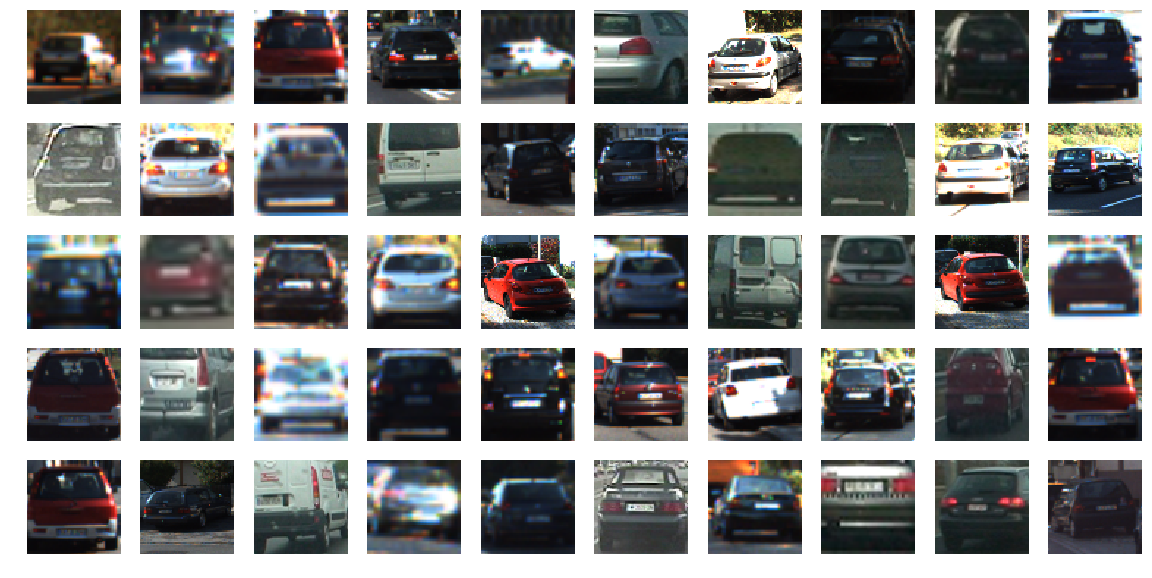

In [19]:
plt.figure(figsize=(20, 10))
for j in range(0, 50):
    plt.subplot(5, 10, j+1)
    plt.imshow(cv2.cvtColor(vehicles_train[j], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

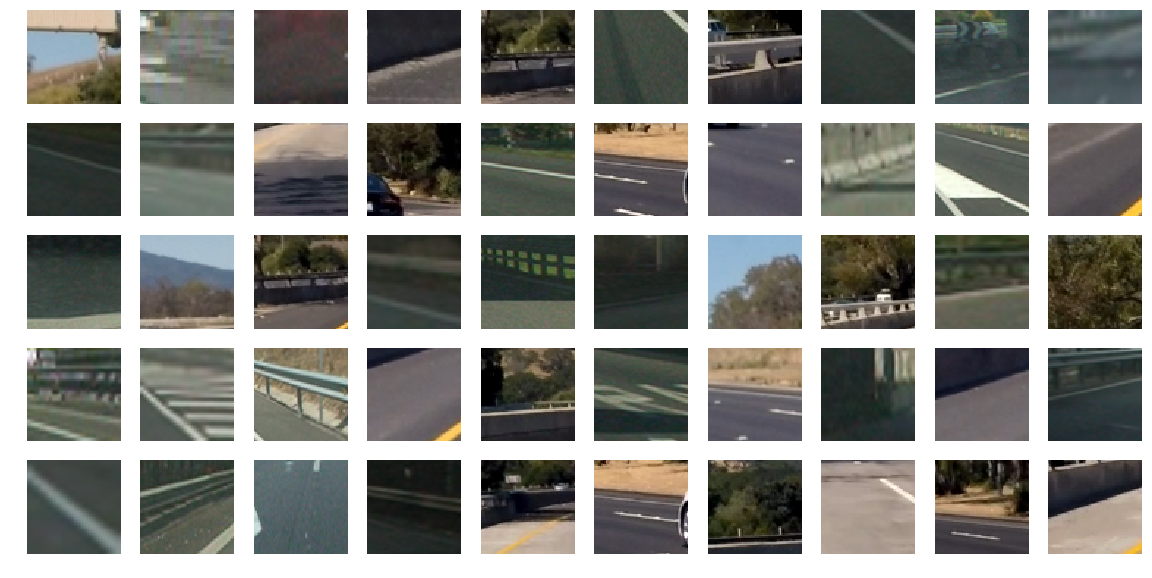

In [20]:
plt.figure(figsize=(20, 10))
for j in range(0, 50):
    plt.subplot(5, 10, j+1)
    plt.imshow(cv2.cvtColor(non_vehicles_train[j], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

In [25]:
extra_vehicles_train = []
for img in vehicles_train:
    extra_vehicles_train.append(cv2.flip(img, 0))
vehicles_train = np.concatenate([vehicles_train, extra_vehicles_train])
print("Vehicles augmented: ", len(vehicles_train))

Vehicles augmented:  16984


In [26]:
extra_non_vehicles_train = []
for img in non_vehicles_train:
    mirrored_img = cv2.flip(img, 0)
    extra_non_vehicles_train.append(mirrored_img)
    extra_non_vehicles_train.append(cv2.flip(img, 1))
    extra_non_vehicles_train.append(cv2.flip(mirrored_img, 1))
non_vehicles_train = np.concatenate([non_vehicles_train, extra_non_vehicles_train])
print("Non-Vehicles augmented: ", len(non_vehicles_train))

Non-Vehicles augmented:  34672


In [27]:
from sklearn.utils import shuffle
X_train = np.concatenate([vehicles_train, non_vehicles_train])
y_train = np.concatenate([np.repeat(1, len(vehicles_train)), np.repeat(0, len(non_vehicles_train))])
X_train, y_train = shuffle(X_train, y_train)
X_valid = np.array(vehicles_validation + non_vehicles_validation)
y_valid = np.concatenate([np.repeat(1, len(vehicles_validation)), np.repeat(0, len(non_vehicles_validation))])

In [28]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

def prepare(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img)
    y_hog = hog(y, orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    u_hog = hog(u, orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    v_hog = hog(v, orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    res = np.concatenate([y_hog, u_hog, v_hog])
    
    return res

In [29]:
X_train_reduced = np.zeros((X_train.shape[0],1188))
for i in range(X_train.shape[0]):
    X_train_reduced[i] = prepare(X_train[i])

/home/tvh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [30]:
from sklearn.svm import LinearSVC

clf = LinearSVC()

clf.fit(X_train_reduced, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
X_valid_reduced = np.zeros((X_valid.shape[0],1188))
for i in range(X_valid.shape[0]):
    X_valid_reduced[i] = prepare(X_valid[i])

/home/tvh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [32]:
pred_train = clf.predict(X_train_reduced)

In [33]:
pred_valid = clf.predict(X_valid_reduced)

In [34]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, pred_train)
acc_valid = accuracy_score(y_valid, pred_valid)
print("Training accuracy: ", acc_train)
print("Validation accuracy: ", acc_valid)

Training accuracy:  0.964302307573
Validation accuracy:  0.941666666667


In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_train, pred_train))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97     34672
          1       0.96      0.93      0.94     16984

avg / total       0.96      0.96      0.96     51656



In [36]:
print(classification_report(y_valid, pred_valid))

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       300
          1       0.96      0.92      0.94       300

avg / total       0.94      0.94      0.94       600



In [37]:
from sklearn.externals import joblib

joblib.dump(clf, 'classifier.pkl')

['classifier.pkl']